# Library and Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import fbprophet
from fbprophet import Prophet

import orbit
from orbit.models.ktrlite import KTRLiteMAP
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_m5daily

import tensorflow_probability as tfp
from tensorflow_probability import sts
import tensorflow as tf
print(tfp.__version__)

Importing plotly failed. Interactive plots will not work.


0.12.1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print(fbprophet.__version__)
print(orbit.__version__)
print(tfp.__version__)

0.7.1
1.0.10
0.12.1


In [4]:
# this is fb data; it looks biased towards fb method
# df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv', parse_dates=['ds'])
# df['y'] = np.log(df['y'])
# test_size = 12

df = load_m5daily()
df = df.rename({'date': 'ds'}, axis=1)
df['y'] = np.log(df['sales'])
test_size = 28

In [5]:
df.head(5)

,ds,sales,Chanukah End,Christmas,Cinco De Mayo,ColumbusDay,Easter,Eid al-Fitr,EidAlAdha,Father's day,...,National,Religious,Sporting,Cinco De Mayo.1,Easter.1,Father's day.1,OrthodoxEaster.1,Cultural.1,Religious.1,y
0,2011-01-29,32631,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.393018
1,2011-01-30,31749,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.365617
2,2011-01-31,23783,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.076726
3,2011-02-01,25412,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.142977
4,2011-02-02,19146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.859849


In [6]:
train_df = df[:-test_size]
test_df = df[-test_size:]

# Facebook Prophet

In [7]:
m = Prophet(seasonality_mode='additive')
_ = m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


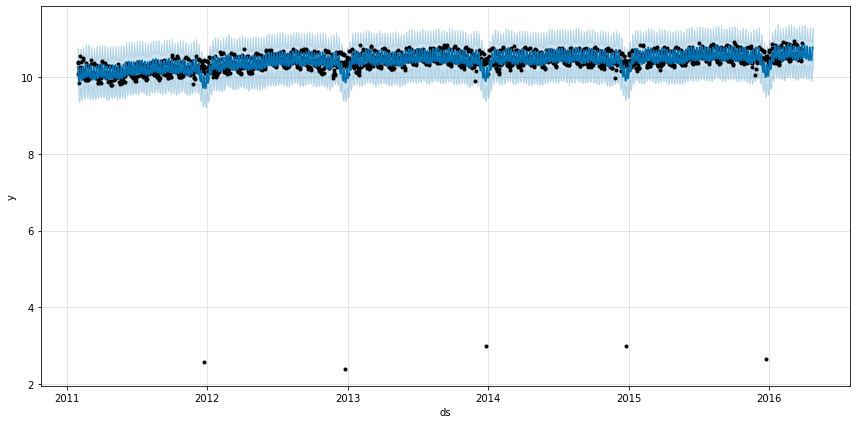

In [8]:
forecast = m.predict(df)
fig = m.plot(forecast, figsize=(12, 6))

In [9]:
prophet_smape = smape(forecast['yhat'].values[-test_size:], test_df['y'].values)
prophet_smape

0.006542157112252036

# Orbit KTRLite

run `pip install git+https://github.com/uber/orbit.git@dev-ktr` to use `dev-ktr` branch

In [10]:
ktr = KTRLiteMAP(response_col='y', date_col='ds', 
                 seasonality=[365.25, 7],  seasonality_fs_order=[10, 3],
#                    seasonality=[12], seasonality_fs_order=[4],
                 degree_of_freedom=30,
                 span_level=0.1,
                 seasonal_knot_pooling_scale=1.0, seasonal_knot_scale=0.1,
               span_coefficients=0.25,
                 level_knot_scale=10.0,
                )
ktr.fit(train_df)

In [11]:
ktr_forecast = ktr.predict(df, decompose=True)
ktr_forecast.tail(5)

,ds,prediction,trend,seasonality_365.25,seasonality_7
1908,2016-04-20,10.521226,10.636643,0.009538,-0.124955
1909,2016-04-21,10.522578,10.636643,0.008691,-0.122755
1910,2016-04-22,10.646916,10.636643,0.007884,0.002390
1911,2016-04-23,10.841446,10.636643,0.007117,0.197687
1912,2016-04-24,10.831221,10.636643,0.006389,0.188190


In [12]:
ktr_smape = smape(ktr_forecast['prediction'].values[-test_size:], test_df['y'].values)
ktr_smape

0.004698906060925582

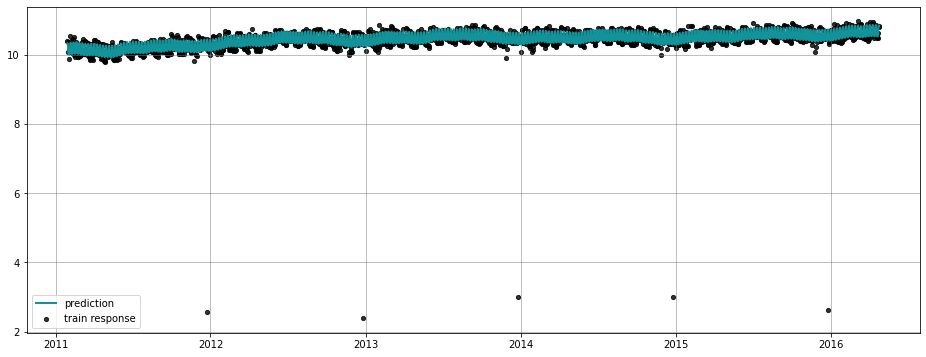

In [13]:
ktr_fig1 = plot_predicted_data(training_actual_df=df, predicted_df=ktr_forecast, date_col='ds', actual_col='y', figsize=(16, 6))

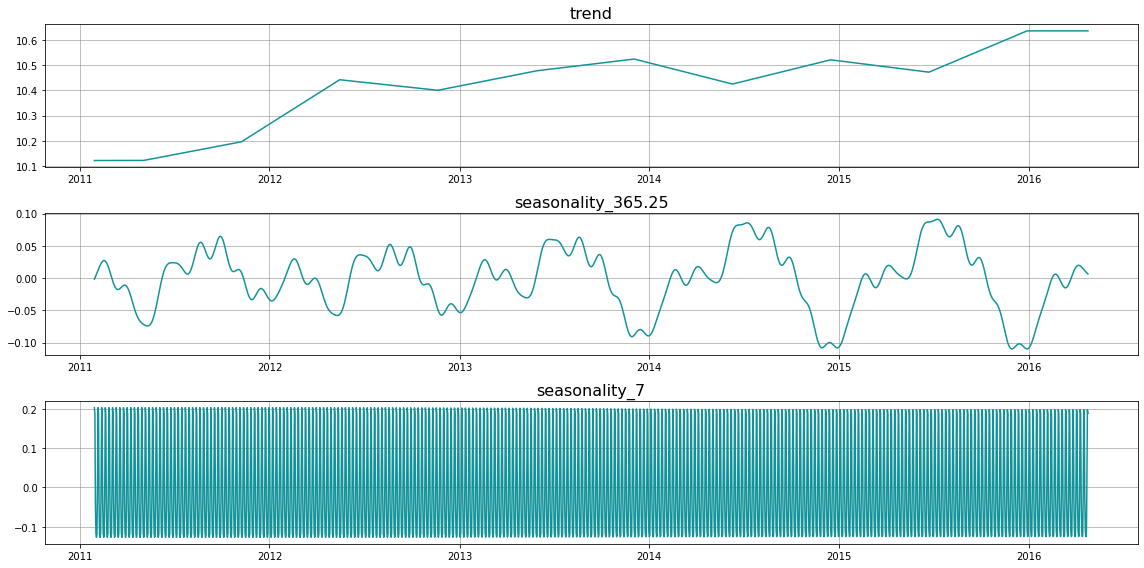

In [14]:
ktr_fig2 = plot_predicted_components(predicted_df=ktr_forecast, date_col='ds', 
                                       plot_components=['trend','seasonality_365.25', 'seasonality_7']
#                                      plot_components=['trend','seasonality_12']
                                    )

# TFP - Structural Time Series (STS)

In [15]:
observed_ts = train_df['y'].values

In [18]:
trend = tfp.sts.LocalLinearTrend(observed_time_series=observed_ts, name='trend')
annual_seasonal = tfp.sts.Seasonal(num_seasons=52, num_steps_per_season=7, observed_time_series=observed_ts, name='annual_seasonality')
weekly_seasonal = tfp.sts.Seasonal(num_seasons=7,  observed_time_series=observed_ts, name='weekly_seasonality')
model = tfp.sts.Sum([annual_seasonal, weekly_seasonal, trend], observed_time_series=observed_ts)

In [19]:
# Build the variational surrogate posteriors `qs`.
variational_posteriors = sts.build_factored_surrogate_posterior(model=model)

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_log_prob(
        observed_time_series=observed_ts),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
    return elbo_loss_curve

In [20]:
elbo_loss_curve = train()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [21]:
parameter_samples = variational_posteriors.sample(50) 

In [22]:
%%time
forecast_dist = sts.forecast(model,
                             observed_time_series=observed_ts,
                             parameter_samples=parameter_samples,
                             num_steps_forecast=test_size)

CPU times: user 2min 7s, sys: 40.2 s, total: 2min 47s
Wall time: 2min 9s


In [23]:
forecast_samples = forecast_dist.sample(500)[..., 0]

In [24]:
forecast_mean = forecast_dist.mean().numpy()[..., 0]

In [25]:
tfp_forecast = pd.DataFrame({'ds': test_df['ds'].values, 'prediction': forecast_mean})

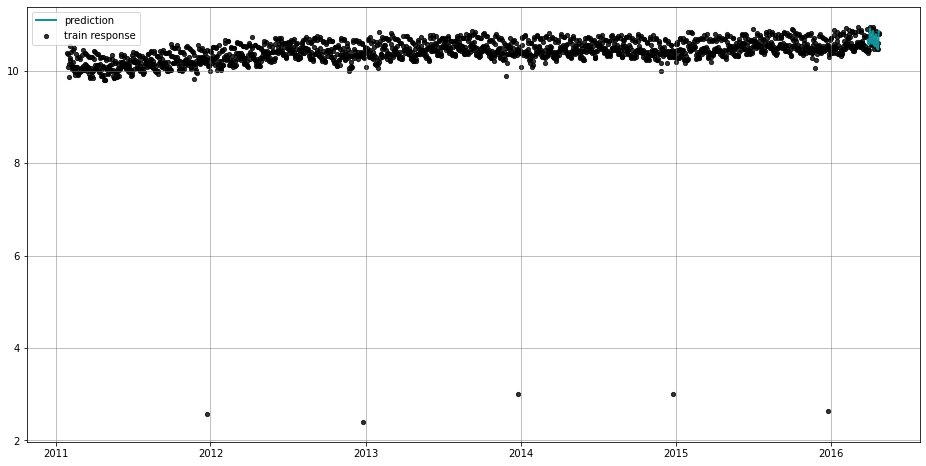

In [26]:
tfp_fig = plot_predicted_data(training_actual_df=df, predicted_df=tfp_forecast, date_col='ds', actual_col='y')

In [27]:
tfp_smape = smape(forecast_mean, test_df['y'].values)
tfp_smape

0.006266487137677546

Notes: TFP takes way too long to generate a forecast.